# Welcome

In this notebook I will show you how I used machine learning to classify benzodiazepines (BDZ) from a selection of drug molecules. For this project I used the chEMBL database of bioactive molecules (https://www.ebi.ac.uk/chembl/). I took the subset of entries which are small molecules that act on the nervous system, giving 507 results. This data is found in the file "SmallMol_NervousSystem.csv".


This notebook requires scikit-learn, pandas and RDKit. RDKit can be downloaded using anaconda (https://www.rdkit.org/docs/Install.html). 


Author: Nicholas Runcie<br>
Date: 23/07/2021<br>
Modified: 07/08/2021<br>

References: <i>Gaulton A, Hersey A, Nowotka M, Bento AP, Chambers J, Mendez D, Mutowo P, Atkinson F, Bellis LJ, Cibrián-Uhalte E, Davies M, Dedman N, Karlsson A, Magariños MP, Overington JP, Papadatos G, Smit I, Leach AR. (2017) 'The ChEMBL database in 2017.' Nucleic Acids Res., 45(D1) D945-D954.</i>

---

**Learning Outcomes:**
* Reading and cleaning Data
* SMILES Strings
* Molecular Fingerprints
* Creating Training and Test Data
* K Nearest Neighbors Algorithm
* Perceptrons
---

# Introduction
The aim of this project was to use machine learning techniques to create a classifier that can successfully classify molecules as either benzodiazepines or not. Benzodiazepines (BDZ) were chosen as they have a very distinct structure and are easily recognisable. Below is an example of Diazepam.

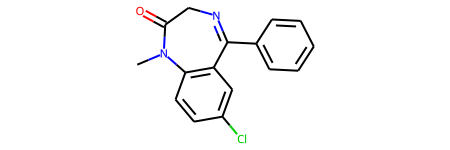

Machine learning classifiers aim to characterise data into discrete categories. For example, you may want to look at an image and determine whether it is a cat or a dog. In this project I will create models which classify BDZs. Strictly speaking it would be very easy to do this without machine learning: simply look for the base BDZ structure within the molecule, however in this project I will train computer models to identify BDZs without the need to explicitly define what a BDZ is. The models in this notebook will be provided training data in order to learn what a BDZ looks like, and then use this information to classify new molecules.

<div class="alert alert-block alert-success">
This project is a great introduction into computational chemistry and machine learning. I would recommend this project to all coding abilities and is suitable for anyone interested in this topic. Computational chemistry is an ever growing field with lots of potential, so this is a great starting point before diving in further.
</div>

In [1]:
#Importing modules required for the notebook
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

---
# Importing Data
The molecule data is held in a "comma separated values" file (csv) which looks a bit like this:
```
CHEMBL485;CODEINE;Small Molecule;4;299.37;...;C18H21NO3";"COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2)N(C)CC[C@]314
```
Each value in this file is seprated using a semicolon (;), so we need to tell python to read in this data using the semicolon as a delimiter. For data analysis it is a good idea to be comfortable with Pandas. I won't explain in depth what is meant by dataframes, so if you are uncertain you can find an online course: I recommend https://www.codecademy.com/learn/data-processing-pandas. Here we can import out molecule data as a dataframe using the code:
```Python
df = pd.read_csv(file_name, delimiter = ";")
```
And then visualise the first 5 rows using ```df.head()``` to make sure everything was imported correctly

In [2]:
df = pd.read_csv("SmallMol_NervousSystem.csv", delimiter = ";")
df.head()

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Structure Type,Inorganic Flag,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles
0,CHEMBL485,CODEINE,CODEINE|CODEINE MONOHYDRATE|Codeine|IDS-NC-005...,Small molecule,4,299.37,55.0,209.0,1.50,41.93,...,MOL,0,22,4,1,0,299.1521,BASE,C18H21NO3,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...
1,CHEMBL2104790,MEPHENOXALONE,Lenetran|MEPHENOXALONE,Small molecule,0,223.23,1.0,2.0,1.18,56.79,...,MOL,0,16,5,1,0,223.0845,NEUTRAL,C11H13NO4,COc1ccccc1OCC1CNC(=O)O1
2,CHEMBL502,DONEPEZIL,Aricept|DONEPEZIL|Donepezil|E-2020,Small molecule,4,379.50,84.0,1235.0,4.36,38.77,...,MOL,0,28,4,0,0,379.2147,BASE,C24H29NO3,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2
3,CHEMBL2106851,NICOMORPHINE,NICOMORPHINE,Small molecule,0,495.54,NaN,NaN,3.37,90.85,...,MOL,0,37,8,0,0,495.1794,BASE,C29H25N3O5,CN1CC[C@]23c4c5ccc(OC(=O)c6cccnc6)c4O[C@H]2[C@...
4,CHEMBL1075733,VALNOCTAMIDE,Axiquel|MCN-X-181|NSC-32363|NSC-34092|VALNOCTA...,Small molecule,3,143.23,4.0,8.0,1.54,43.09,...,MOL,0,10,2,2,0,143.1310,NEUTRAL,C8H17NO,CCC(C)C(CC)C(N)=O


---
# Cleaning Data
When I first attempted this project I spent hours trying to debug my code and figure out why it wasn't working. After literally 24 hours I realised the data I downloaded was not in the format I had expected. In order to analyse molecular structure we need to have a "SMILES string". This is a series of charactes which describe the whole structure of an organic molecule and can be used to draw the molecule into a readable format.

For our data analysis we need to ensure every molecule has a smiles string and delete any rows which do not. By manually looking through the data I found "NICOTINE POLACRILEX" which seems to be a "product" rather than a specific drug. As such there is no smiles string. I want to "drop" all rows that do not have a "Smiles" column entry. Empty cells are given a NaN value, and pandas has the option to drop rows with a NaN value.
```Python
df = df.dropna(subset=["Smiles"])
```
The ```subset``` parameter defined specifically which columns to look at. Without this paramater every row in the dataframe that contained any NaN values would be dropped, which is most of them. Running the next three cells shows the number of entries in the dataframe has decreased by one showing the ```df.dropna``` method was successful.


In [3]:
len(df)

507

In [4]:
df[df["ChEMBL ID"] == "CHEMBL1201536"]

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Structure Type,Inorganic Flag,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles
16,CHEMBL1201536,NICOTINE POLACRILEX,COMMIT|NICORETTE (MINT)|NICOTINE POLACRILEX|Ni...,Small molecule,4,NaN,NaN,NaN,NaN,NaN,...,NONE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = df.dropna(subset=["Smiles"])
print(len(df))

506


---
# SMILES Strings
"Simplified molecular-input line-entry system" (SMILES strings) are a way to encode molecular strucutres. It is easy for chemists to draw molecular structures on paper, however drawings are not helpful for a computer. SMILES strings give us a way to input a molecular structure into our code. At first these strings may look confusing, however if you try playing around with them they soon make sense. Here are some examples:

|Molecule|SMILES|
|:-:|:-:|
|Methane|C|
|Ethane|CC|
|Ethene|C=C|
|Cyclohexane|C1CCCCC1|
|Benzene|c1ccccc1   **or**    C1=CC=CC=C1|
|Diazepam|CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3|

**Resources**<br>
Wiki: https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system <br>
Daylight: https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html<br>

---
# Create Molecule Column using RDKit
RDKit's main use is the ability to create molecule "objects". An object is a collection of data and functions that can act on the data. In this case, our objects are a python representation of molecules. Mol objects can be created from a smiles string using the code:
```Python
molecule_object = Chem.MolFromSmiles(smiles_string)
mol = Chem.MolFromSmiles("Cc1ccccc1")
```
In our dataframe we want to create a new column filled with objects corresponding the the smiles string. Fortunately RDKit has ```PandasTools``` which can do this for us. 
```Python
PandasTools.AddMoleculeColumnToFrame(data_frame,smiles_column,name_for_molecule_column',includeFingerprints=True)
PandasTools.AddMoleculeColumnToFrame(df,'Smiles','Mol',includeFingerprints=True)
```
```includefingerprints``` is an optional parameter; I am not yet sure how helpful it is.

Run ```df.head()``` and scroll to the right. If the image is small you can double click it to make it bigger. We have now created 506 molecule objects.

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Inorganic Flag,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,Mol
0,CHEMBL485,CODEINE,CODEINE|CODEINE MONOHYDRATE|Codeine|IDS-NC-005...,Small molecule,4,299.37,55.0,209.0,1.50,41.93,...,0,22,4,1,0,299.1521,BASE,C18H21NO3,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,
1,CHEMBL2104790,MEPHENOXALONE,Lenetran|MEPHENOXALONE,Small molecule,0,223.23,1.0,2.0,1.18,56.79,...,0,16,5,1,0,223.0845,NEUTRAL,C11H13NO4,COc1ccccc1OCC1CNC(=O)O1,
2,CHEMBL502,DONEPEZIL,Aricept|DONEPEZIL|Donepezil|E-2020,Small molecule,4,379.50,84.0,1235.0,4.36,38.77,...,0,28,4,0,0,379.2147,BASE,C24H29NO3,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,
3,CHEMBL2106851,NICOMORPHINE,NICOMORPHINE,Small molecule,0,495.54,NaN,NaN,3.37,90.85,...,0,37,8,0,0,495.1794,BASE,C29H25N3O5,CN1CC[C@]23c4c5ccc(OC(=O)c6cccnc6)c4O[C@H]2[C@...,
4,CHEMBL1075733,VALNOCTAMIDE,Axiquel|MCN-X-181|NSC-32363|NSC-34092|VALNOCTA...,Small molecule,3,143.23,4.0,8.0,1.54,43.09,...,0,10,2,2,0,143.1310,NEUTRAL,C8H17NO,CCC(C)C(CC)C(N)=O,

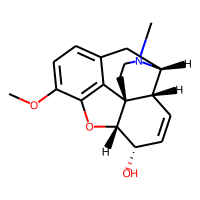
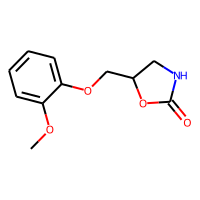
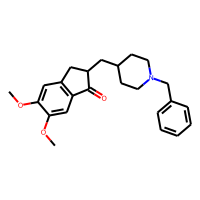
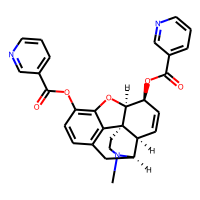
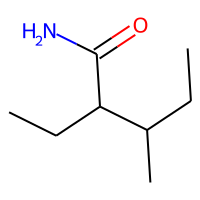

In [6]:
PandasTools.AddMoleculeColumnToFrame(df,'Smiles','Mol',includeFingerprints=True)
df.head()
#A warning in a red box may pop up. Ignore that. 

---
# Labeling Benzodiazepines 
Our data does not have any label to indicate what drug family each molecule is in. To overcome this we need to find a way to identify all our BDZs. The following method I chose is not perfect, however it is reasonably effective. By considering the following list of BDZs, see if you can spot a pattern:
* diazepam 
* alprazolam 
* flurazepam
* triazolam

Notice how they all end in "AM". This is common for BDZs as most contain the suffix "azolam" or "azepam". As such I wrote the following code to create a new binary column "BDZ" that is True for all molecules whos name ends "AM" and False for all others.

## Imperfect

<div class="alert alert-block alert-danger">
<b>This method is flawed for two reasons:</b>
<ol>
    <li>Some BDZs do not end in AM</li>
    <li>Some other molecules do end in AM</li>
    </ol>
    As such I have incorrectly labeled these molecules. It would have been better to classify based on ending in "azolam" or "azepam", however the results from using this data are actually quite interesting so I have decided to mainting the flawed data. As a whole most of the drugs were correctly classified and so the classifiers were still successful.
</div>


## Alternative
A more advanced way to identify BDZs would be to use a SMILES or SMARTS string which represents the base strucuture of all BDZs and then to search through all structures for this specific pattern.

In [7]:
df["BDZ"] = df.apply(lambda row : True if row["Name"][-2:] == "AM" else False, axis = 1)

#The line below shows how many molecules were classified as BDZ and how many were not.
#As you can see 45 molecules were identified as BDZ, approx 10% of total molecules.
df.BDZ.value_counts()

False    461
True      45
Name: BDZ, dtype: int64

In [8]:
#Run this cell to investigate the BDZ column
#df.head()

---
# Fingerprints
Molecular fingerprints are a list of binary values with each index representing a different type of molecular substructure present in the target molecule. Fingerprinting allows us to capture features and characteristics of our molecules into a binary vector which we can later use to compare molecules with eachother. The figure below shows an example fingerprint for a molecule containing a carbonyl, amine fragment, and an aromatic ring with a para chlorine. 


<div class="alert alert-block alert-info">
<b>Note:</b> Different fingerprinting systems have different indexes and substructures. The above example is a made up fingerprint. Real fingerprints will be discussed later in this notebook.</div>

For our test data we need to obtain the fingerprint of each molecule and save this in a corresponding dataframe. (I am still learning Pandas so I am not certain on terminology, however I believe in this case the fingerprint would be stored as a series). This code creates the ```mol_fp``` series of fingerprints and then converts it into a list.
```Pythin
mol_fp = df.apply(lambda row: Chem.RDKFingerprint(row["Mol"]), axis = 1)
mol_fp = list(mol_fp)
```

---
# Creating Training and Test data
In order train our models we need to have a set of training data. This data needs to contain both the features of the molecule we are interested in analysing (fingerprints) along with a corresponding label of whether the molecule is BDZ. Similarly in order to test our models we need a test data set of the same form. The table below shows what our training and test data will look like. We will give our model each fingerprint and get it to learn which correspond to Benzodiazepines 

|Features (Fingerprints)|Label (BDZ)|
|:-:|:-:|
|000101100001|0|
|000010010000|1|
|110101100001|0|
|000101101101|0|
|000010010001|1|

## Labels
Labels are the target for our models to aim for. Given all the features in our data set (in our case the fingerprints) we want our model to learn which correspond to BDZ and which don't. The list of labels corresponds to each fingerprint and is true for all that are BDZ, ie the ```df["BDZ"]``` column. Depending on the project the labels column may be binary, discreet, or continous.

## Splitting Data
Sklearn has the convenient function ```train_test_split``` which allows us to give training data and associated labels, define ```test_size``` which says how many entries we want in the test data, and ```random_state``` to make the random splitting reproducable. As a rule of thumb 80% of our data should be allocated to the training set and the rest used for test data.

```python
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 1)
```

In [9]:
from sklearn.model_selection import train_test_split
#Creating a series containing all the molecular fingerprints
mol_fp = df.apply(lambda row: Chem.RDKFingerprint(row["Mol"]), axis = 1)
mol_fp = list(mol_fp)

#Creating a series containing all the truth values from the BDZ column
labels = df["BDZ"]

#Separating all the data randomly into training and test data with corresponding labels. test_size allocates 20% of
#all the data into the test set with the rest in training set. random_state = 1 ensures each time we run this line we
#get the same data allocations, allowing for reproduceability. 
train_data, test_data, train_labels, test_labels = train_test_split(mol_fp, labels, test_size = 0.2, random_state = 1)

#To ensure a good distribution of the drugs between training and test data
#This line counts how many BDZs were allocated to each of training and test data. We see that more than 20% BDZ were
#Allocated to the test data, however this was okay for the classifiers. 
print("Training Label \n", train_labels.value_counts())
print()
print("Test Labels \n", test_labels.value_counts())

Training Label 
 False    373
True      31
Name: BDZ, dtype: int64

Test Labels 
 False    88
True     14
Name: BDZ, dtype: int64


---
# K Nearest Neighbors
We are now ready to create a classifier. Many different models exist for this and the choice of model depends on your data and what you want to achieve. Here I have chosen K Nearest Neighbors (KNN). Strictly speaking this probably is not the best choice of model for this data, but it still works. This model plots all training data points into an N dimensional space then classifies test points by comparing the (euclidean) distance between the test point and every training point. The K nearest training points in space to the test point (neighbors) are taken and the test point is then classified as the average of these points. 

Below is a diagram to explain the KNN model. Here we have two types of point, red triangles and blue circles, and we have three points we want to classify represented by green squares. It is reasonable to assume that points that are closer together are more likely to be similar. Looking at point ```A``` we can confidently assume it is a red triangle. Computationally we could determine this by looking at the 5 points nearest to ```A``` and then classify the point as the most common of the neighbors. ```A```'s 5 nearest neighbors are 4 red triangles and 1 blue circle, so we classify it as a red triangle.

Similarly point ```C``` can be clearly classified as a blue circle as all nearby points are blue circles. Again computationally we look at the 5 nearest neighbors and take the average and hence classify ```C``` as a blue circle.

Point ```B``` represents and interesting case. Here the closest neighbor is a red triangle, however if we look a bit futher we see the area is more likely to represent blue circles. In this case the red triangle could be an outliar and not represent the overall trend of the data. If we were to classify the point according to just this neighbor we would be "over fitting" our data and miss the general trend. By taking the average of a few close points we can avoid the problem of overfitting. The best choice of K will depend on the data and can be found by testing multiple K values. 




The main idea behind this classifier is that points with similar features are likely to have similar properties. In our case, if a point is very close to many BDZs, sharing commonality with much of the fingerprint, then this molecule is also likely to be a BDZ. 


## Code
The code for creating and testing classifiers is very simple with SKlearn. They all follow the same form.
```
import classifier
instantiate classifier object
classifer.fit(training_data,training_labels)
classifier.predict(test_data)
classifier.score(test_data,test_labels)
```
The classifier needs to be imported from sklearn. The classifier object then needs to be instantiated ```classifier = KNeighborsClassifier(n_neighbors = 5)```. For knn you also have to pass in the parameter for how many neighbors to consider, however most classifiers are instantiated with no parameters. The classifier is then trained by fitting data by using ```classifier.fit(training_data,training_labels)```. To find the predictions the classifier makes for any data, you can do ```prediction = classifier.predict(test_data)```, this test data can be your test data we made earlier, or it can be your own new individual test data. Finally you can find how successfuly your classifier was by using ```classifier.score(test_data,test_labels)``` which returns the percentage accuracy.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(train_data,train_labels)

knn_prediction = classifier.predict(test_data)
classifier.score(test_data,test_labels)

0.9607843137254902

## What were the Incorrect Predictions
96% is pretty impressive! However I am interesting in finding what was not correctly classified. We can create a confusion matrix which creates 2D array of how many entries were classified in each category.
```Python
from sklearn import metrics
metrics.confusion_matrix(test_labels, knn_prediction)
```

The output is of form:   

|| False | True |
|:-:|:-:|:-:|
|**False**|86|2|
|**True**|2|12|

We see 86 non BDZs and 12 BDZs were correctly classified, while 2 were wrongly classified as BDZ and 2 were wrongly classified as non BDZ.

In [11]:
from sklearn import metrics
metrics.confusion_matrix(test_labels, knn_prediction)

array([[86,  2],
       [ 2, 12]], dtype=int64)

__The following code finds all the incorrectly classified entries and displays them.__
Have a look at the Mol and BDZ column and try and explain why each molecule was incorrectly classified.

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,Mol,BDZ
219,CHEMBL36633,OXIRACETAM,CGP 21690E|CGP-21690E|GNF-PF-1005|OXIRACETAM,Small molecule,2,158.16,17.0,38.0,-1.94,83.63,...,11,5,3,0,158.0691,NEUTRAL,C6H10N2O3,NC(=O)CN1CC(O)CC1=O,,True
377,CHEMBL1213460,ETHYL LOFLAZEPATE,ETHYL LOFLAZEPATE,Small molecule,0,360.77,17.0,19.0,3.20,67.76,...,25,5,1,0,360.0677,NEUTRAL,C18H14ClFN2O3,CCOC(=O)C1N=C(c2ccccc2F)c2cc(Cl)ccc2NC1=O,,False
335,CHEMBL36994,ANIRACETAM,ANIRACETAM|Ampamet|Draganon|Memodrin|RO 13-505...,Small molecule,0,219.24,129.0,326.0,1.46,46.61,...,16,4,0,0,219.0895,NEUTRAL,C12H13NO3,COc1ccc(C(=O)N2CCCC2=O)cc1,,True
474,CHEMBL49,BUSPIRONE,BCI-024|BUSPIRONE|Buspar|Buspirone,Small molecule,4,385.51,175.0,1035.0,2.09,69.64,...,28,7,0,0,385.2478,NEUTRAL,C21H31N5O2,O=C1CC2(CCCC2)CC(=O)N1CCCCN1CCN(c2ncccn2)CC1,,False

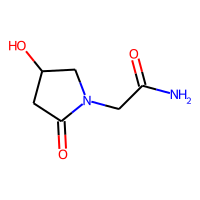
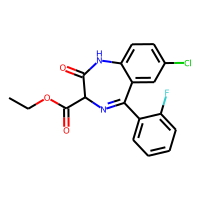
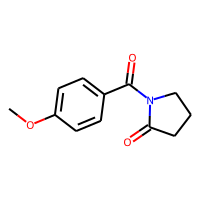
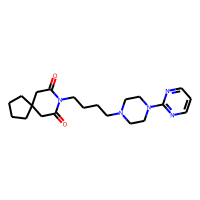

In [12]:
s = test_labels.reset_index()

knn_inccorect_predictions = []
for i in range(len(s)):
    if s["BDZ"].iloc[i] != knn_prediction[i]:
        #print(s.iloc[i]["index"])
        #print("Expected: ", s["BDZ"].iloc[i])
        #print("Prediction: ", predictionk[i])
        knn_inccorect_predictions.append(s.iloc[i]["index"]-1)
        #print()

df.iloc[knn_inccorect_predictions]

# Explanation
### False Negatives: ```OXIRACETAM``` ```ANIRACETAM```
These molecules were identified as false negatives. In the training set these molecules were listed as BDZ as they contained the "AM" suffix. However the classifier classified these as not BDZ. This is interesting as looking at the molecule it is clear these are in fact not BDZs, that is the training data was incorrect and the classifier was successfully able to classify them according to real chemistry, despite the poor training data.

To avoid this happening again, the training data should be more carefully created by considering only actual BDZs. This can be done by considering a longer suffix.

### False Positives: ```ETHYL LOFLAZEPATE``` ```BUSPIRONE```
These molecules were listed in the test data as not being BDZ, however were classified as BDZ positive results. Looking at ```ETHYL LOFLAZEPATE``` we can see this strucuture is definity a BDZ, and a google search confirms this. Looking at the name we see it does not end in "AM" and as such our test data was incorrect and our classifier was yet again successful at correctly classifying a BDZ given the positive result.

Finally, ```BUSPIRONE```is more challening to explain. This molecule was definitly a false positive and is the only example in the test data of an actual misclassification. To understand this result we need to understand the fingerprint and compare features. In order to be classified as a BDZ, this molecule must have a sufficient number of features in its fingerprint to make it similar to BDZs.

Straight away by comparing molecules you can see they both have nitrogens, carbonyl, rings, aromtic rings etc. These similarities are all represented in the fingerprints.

## Fingerprint Comparisons
I found this very interested so sought to try and find specifically which fingerprint features were in common between both compounds. The follow code achieves this.

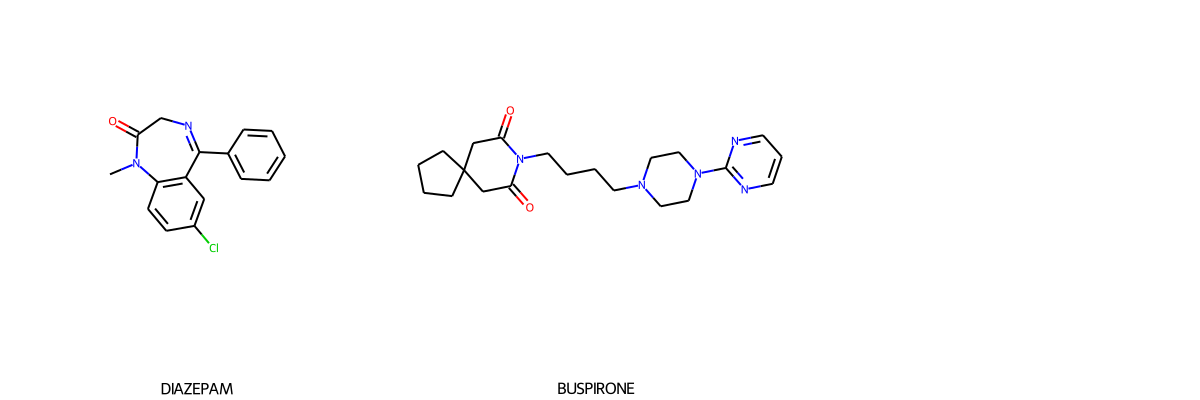

In [13]:
from rdkit.Chem import Draw
DIAZEPAM = Chem.MolFromSmiles("CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3")
BUSPIRONE = Chem.MolFromSmiles("O=C1CC2(CCCC2)CC(=O)N1CCCCN1CCN(c2ncccn2)CC1")
px = 400
Draw.MolsToGridImage((DIAZEPAM,BUSPIRONE), subImgSize=(px,px), legends=("DIAZEPAM","BUSPIRONE"))

In [14]:
from rdkit.Chem import rdMolDescriptors
#Credit for the following code
#http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html

In [15]:
#This code obtains the fingerprints for DIAZEPAM and BUSPIRONE
rdkbi1 = {}
rdkfp1 = Chem.RDKFingerprint(DIAZEPAM, maxPath=5, bitInfo=rdkbi1)
l1 = list(rdkfp1.GetOnBits())
rdkbi2 = {}
rdkfp2 = Chem.RDKFingerprint(BUSPIRONE, maxPath=5, bitInfo=rdkbi2)
l2 = list(rdkfp2.GetOnBits())

In [16]:
#This code finds all fingerprints common to both DIAZEPAM and BUSPIRONE
list1_as_set = set(l1)
intersection = list1_as_set.intersection(l2)
intersection_as_list = list(intersection)
#print(intersection_as_list)

## Fingerprint Visualisation
In the cell bellow you can see DIAZEPAM and BUSPIRONE. In the following cell I have code which visualises all the shared fingerprints of each molecule, comapred side by side. On the left column you can see all the DIAZEPAM fingerprint structures and on the right you can see all the equivilent BUSPIRONE fingerprint strucutres. The fingerprints are visualised according the the molecule they came from: the molecule is made invisible and all atoms that make up the fingerprint are made visible. This makes the strucutres a bit messy and I am not sure how to tidy it up. Regardless, you can immedialty see where in the molecule the similarities occur. A total of 64 features are shared between the two molecules.

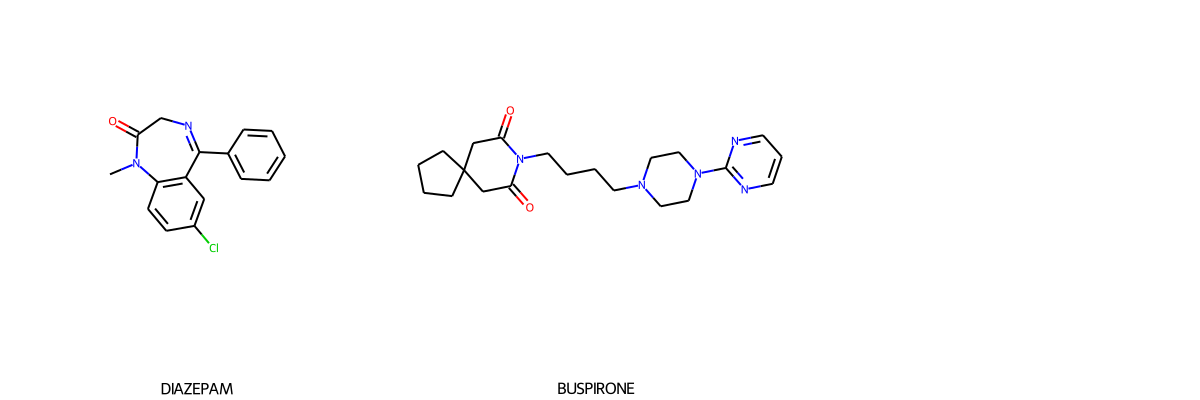

In [17]:
Draw.MolsToGridImage((DIAZEPAM,BUSPIRONE), subImgSize=(px,px), legends=("DIAZEPAM","BUSPIRONE"))

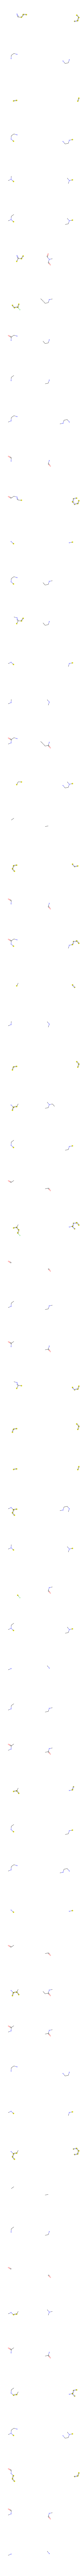

In [18]:
#interesting = [1408, 1907, 1550]
interesting = intersection_as_list
tpls = []
for x in interesting:
    tpls.append((DIAZEPAM,x,rdkbi1))
    tpls.append((BUSPIRONE,x,rdkbi2))
px = 400
Draw.DrawRDKitBits(tpls,molsPerRow=2,subImgSize=(px,px))

<div class="alert alert-block alert-info">
As you can see, despite DIAZEPAM and BUSPIRONE being very different molecules, they do share a significant number of features with eachother, hence explaining why they were identified as being similar.</div>

---
# Perceptron
This classifier is a good example of a machine learning algorithm. Perceptrons are inspired by the firing of neurons. This classifier takes in a vector of features (the fingerprint is a binary vector), applies weightings to each index of the vector, and calculates a weighted sum. If the weighted sum exceeds a threshold value, the perceptron "fires" and gives an output. The perceptron is trained by an iterative algorithm where it attempts to classify the data and if it makes an error is returns to its weightings and modifies each weight accordingly. After a few cycles of training the perceptron is able to classify data with high accuracy.

This model is more complicated that the previous, and it is too complicated to explain in this notebook, so if you are interested in learning how it works it is worth finding a youtube video.

ultimately the perceptrons aims to find a boundary (plane) which separates our points. Below is an example of how a perceptron may try to separate our triangles and circles. This classifier would classify any points left of the boundary as red triangles, and anything right of the boundary and blue circles. 



In the case of this project, we are using vectors with thousands of dimensions, so trying to visualise the boundary is essentially impossible. The model below finds a 2000 (ish) dimensional plane which separates most molecules into either BDZ or not BDZ. Interpret that as you will. 

In [19]:
from sklearn.linear_model import Perceptron

classifier = Perceptron(max_iter=40)
classifier.fit(train_data,train_labels)
classifier.score(test_data, test_labels)

0.9901960784313726

In [20]:
perceptron_prediction = classifier.predict(test_data)

In [21]:
metrics.confusion_matrix(test_labels, perceptron_prediction)

array([[88,  0],
       [ 1, 13]], dtype=int64)

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,Mol,BDZ
335,CHEMBL36994,ANIRACETAM,ANIRACETAM|Ampamet|Draganon|Memodrin|RO 13-505...,Small molecule,0,219.24,129.0,326.0,1.46,46.61,...,16,4,0,0,219.0895,NEUTRAL,C12H13NO3,COc1ccc(C(=O)N2CCCC2=O)cc1,,True

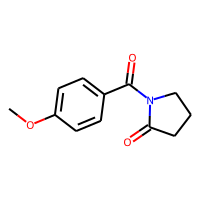

In [22]:
s = test_labels.reset_index()

perceptron_inccorect_predictions = []
for i in range(len(s)):
    if s["BDZ"].iloc[i] != perceptron_prediction[i]:
        #print(i)
        #print("Expected: ", s["BDZ"].iloc[i])
        #print("Prediction: ", perceptron_prediction[i])
        perceptron_inccorect_predictions.append(s.iloc[i]["index"]-1)
        
df.iloc[perceptron_inccorect_predictions]

---
# Discussion

The results of the perceptron are surprising. This model achived 99% accuracy and only made a single mistake with ```ANIRACETAM```. This molecule was incorectly labeled in the data set as a BDZ, when in reality it is not. As such the error in this case came from the data and not the perceptron.

This result facinated me. When I was working on this notebook I first throught the perceptron had won against the K Nearest Neighbors classifier given the greater percentage accuracy, which was in aggreement with my expections. However, after analysising the results I realised the perceptron achieved something beyond what I had expected. Analysis of the KNN classifier found 3 examples of poor training data where molecules were incorrectly labeled being BDZs and not. 

In this case however, the perceptron has successfully classified almost all the data into the correct category according to the BDZ column, include cases where I had misclassified the data. This means the perceptron successfully learned how to classifiy the data according to the poor labels, and was able to predict which molecules were incorectly classified in the data.

This was surprising and took me a while to figure out how it managed this feat. The problem with perceptrons is that it is quite hard to analyse the weightings and explain where results come from. It is in principle possible with a single perceptron, however it would be quite a task. 

# Power of Machine Learning
I then realised where this result came from. The clue is in the "incorrectly" classified molecule ```ANIRACETAM```. This molecule ends with "AM" hence was listed as a BDZ. I had made the assumption that all molecules that end in "AM" are BDZ. However it turns out there is another drug family that ends in "AM" called Racetam. Molecules include: ```aniracetam```, ```oxiracetam```, ```pramiracetam```, ```phenylpiracetam```. Some of these would have existed in the training data labeled as BDZ. As such the perceptron learned to identify these molecules and classifiy them as BDZ.

The perceptron was therefore classifying molecules according to "benzodiazepine or racetam" and the positive classifications indicate a drug is either benzodiazepine or racetam. 

# Comparison
Comparing these two classifiers we find that the perceptron was more successful at classifying the data given to it, while the KNN algorithm was more successful as classifying data acording to what was expected in real life. The KNN algorithm was able to avoid outliers thrown up by the racetams due to the nature of the algorithm. Depending on how many racetams were in the data set, and how similar they were to eachother, it may have been hard to create a cluster of points that all had the BDZ label. As such these "imposter" molecules were able to be classified as not being BDZ. This result was accidental and given a larger training set the KNN quite possibly would also start classifying racetams as BDZ. 

# Conclusion
In conclusion, both classifier models were successfuly at classifying benzodiazepine from a selection of drug molecules that act on the nervous system. The K-Nearest Neighbors algorithm was more successful at classifying molecules according to the real world expectation of how the drug should be classified, whereas the perceptron was able to classify the data more successfully according to the flawed training and test data. This experiment resulting in me finding the new drug class of "racetam" which I had not previously known. 

The models created in this notebook can be improved by creating higher quality training data. This can be achieved by classifying molecules according to a longer suffix of "azolam" or "azepam" or by searching for a specific BDZ substructure withing the molecules. Alternative classifier models can also be explored, such as "Logistic regression" and "Support Vectors".